In [12]:
from abc import ABC, abstractmethod
import numpy as np

# Activation function interface
class ActivationFunction(ABC):
    @abstractmethod
    def output(self, x: np.ndarray) -> np.ndarray:
        pass

    @abstractmethod
    def derivative(self, x: np.ndarray) -> np.ndarray:
        pass

# Sigmoid activation implementation
class Sigmoid(ActivationFunction):
    def output(self, x: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-x))

    def derivative(self, x: np.ndarray) -> np.ndarray:
        return self.output(x) * (1 - self.output(x))

# ReLU activation implementation
class ReLU(ActivationFunction):
    def output(self, x: np.ndarray) -> np.ndarray:
        return np.maximum(0, x)

    def derivative(self, x: np.ndarray) -> np.ndarray:
        return np.where(x > 0, 1, 0)

# Weighted ReLU activation implementation
class WeightedReLU(ActivationFunction):
    def __init__(self, alpha: float = 0.01):
        self.alpha = alpha

    def output(self, x: np.ndarray) -> np.ndarray:
        return np.maximum(self.alpha * x, x)

    def derivative(self, x: np.ndarray) -> np.ndarray:
        return np.where(x > 0, 1, self.alpha)

# Tanh activation implementation
class Tanh(ActivationFunction):
    def output(self, x: np.ndarray) -> np.ndarray:
        return np.tanh(x)

    def derivative(self, x: np.ndarray) -> np.ndarray:
        return 1 - np.tanh(x)**2

# Cost function interface
class CostFunction(ABC):
    @abstractmethod
    def derivative(self, target: np.ndarray, output: np.ndarray) -> np.ndarray:
        pass

# Mean squared cost implementation
class MeanSquared(CostFunction):
    def derivative(self, target: np.ndarray, output: np.ndarray) -> np.ndarray:
        return output - target

# Weight initialization class
class WeightInitializer:
    @staticmethod
    def initialize_weights(input_size: int, output_size: int) -> np.ndarray:
        # Initialize weights with small random values around zero
        return np.random.randn(input_size, output_size)

# Perceptron class
class Perceptron:
    def __init__(self, input_size: int, activation: ActivationFunction):
        self.weights = WeightInitializer.initialize_weights(input_size, 1)
        self.bias = np.zeros((1, 1))  # Initialize bias close to zero
        self.activation = activation

    def feedforward(self, X: np.ndarray) -> np.ndarray:
        self.output = self.activation.output(np.dot(X, self.weights) + self.bias)
        return self.output

    def backward(self, X: np.ndarray, error: np.ndarray, learning_rate: float) -> np.ndarray:
        delta = error * self.activation.derivative(self.output)
        self.weights += X.T.dot(delta) * learning_rate
        self.bias += np.sum(delta, axis=0, keepdims=True) * learning_rate
        return np.dot(delta, self.weights.T)

# Layer class
class Layer:
    def __init__(self, input_size: int, num_neurons: int, activation: ActivationFunction):
        self.perceptrons = [Perceptron(input_size, activation) for _ in range(num_neurons)]

    def feedforward(self, X: np.ndarray) -> np.ndarray:
        return np.concatenate([perceptron.feedforward(X) for perceptron in self.perceptrons], axis=1)

    def backward(self, X: np.ndarray, errors: np.ndarray, learning_rate: float) -> np.ndarray:
        delta_accumulated = [perceptron.backward(X, errors[:, i:i+1], learning_rate) for i, perceptron in enumerate(self.perceptrons)]

        return np.concatenate(delta_accumulated, axis=1)

# NeuralNetwork class
class NeuralNetwork:
    def __init__(self, layers: list, cost: CostFunction):
        self.layers = layers
        self.cost = cost

    def train(self, input_data: np.ndarray, target_data: np.ndarray, epochs: int, learning_rate: float) -> None:
        for epoch in range(epochs):
            layer_input = input_data
            layer_outputs = [layer_input]

            # Forward pass
            for layer in self.layers:
                layer_output = layer.feedforward(layer_input)
                layer_outputs.append(layer_output)
                layer_input = layer_output

            # Backward pass
            output_error = self.cost.derivative(layer_output, target_data)
            for layer, layer_output in zip(reversed(self.layers), reversed(layer_outputs[:-1])):
                layer_input = layer.backward(layer_output, output_error, learning_rate)
                output_error = layer_input

    def predict(self, input_data: np.ndarray) -> np.ndarray:
        layer_input = input_data
        for layer in self.layers:
            layer_input = layer.feedforward(layer_input)
        return layer_input

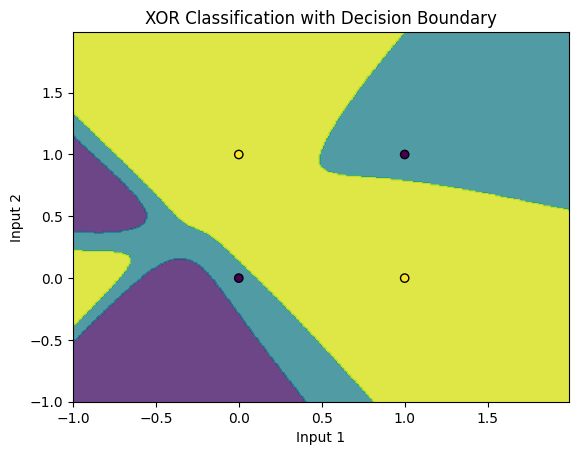

In [18]:
import matplotlib.pyplot as plt

# Training data
input_data = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
target_data = np.array([[0], [1], [1], [0]])

# Creating and training the neural network
nn = NeuralNetwork([
        Layer(2, 5, Tanh()),
        Layer(5, 5, Tanh()),
        Layer(5, 1, Tanh()),
    ], MeanSquared())

nn.train(input_data, target_data, epochs=10000, learning_rate=0.1)

# Create a meshgrid of points
h = 0.01
x_min, x_max = input_data[:, 0].min() - 1, input_data[:, 0].max() + 1
y_min, y_max = input_data[:, 1].min() - 1, input_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]

# Predict the function value for the whole grid
Z = np.round(nn.predict(grid)).reshape(xx.shape)

# Plot the contour and training examples
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(input_data[:, 0], input_data[:, 1], c=target_data.ravel(), edgecolors='k')
plt.xlabel('Input 1')
plt.ylabel('Input 2')
plt.title('XOR Classification with Decision Boundary')
plt.show()